#### Preamble

Use the environment `shrec`

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline

Use driver detection to find combinatoric driver among a set of interacting genes.

In [ ]:

from scipy.stats import spearmanr

from sklearn.decomposition import PCA
y_pca = PCA(n_components=1).fit_transform(X_measure)[:, 0]
print(spearmanr(y_driver, y_pca))
plt.figure()
plt.plot(y_driver, y_pca, '.')


from sksfa import SFA
sfa = SFA(n_components=1)
y_sfa = sfa.fit_transform(X_measure)[:, 0]
print(spearmanr(y_driver, y_sfa))
plt.figure()
plt.plot(y_driver, y_sfa, '.')

## ICA
from sklearn.decomposition import FastICA
ica = FastICA(n_components=1)
y_ica = ica.fit_transform(X_measure)[:, 0]
print(spearmanr(y_driver, y_ica))
plt.figure()
plt.plot(y_driver, y_ica, '.')

import sktime.transformations.series.kalman_filter as kf
y_kf = kf.KalmanFilterTransformerFP(state_dim=1).fit_transform(X_measure)[:, 0]
print(spearmanr(y_driver, y_kf))
plt.figure()
plt.plot(y_driver, y_kf, '.')

from baseline_models import CCATimeSeries
tau = 10
cca = CCATimeSeries(n_components=1, time_lag=tau)
cca.fit(X_measure)
y_cca = cca.transform(X_measure)
print(spearmanr(y_driver, y_cca))
plt.figure()
plt.plot(y_driver, y_cca, '.')

from baseline_models import FourierPCA
fpca = FourierPCA(n_components=1)
y_fpca = fpca.fit_transform(X_measure)#[:, 0]
print(spearmanr(y_driver, y_fpca))
plt.figure()
plt.plot(y_driver, y_fpca, '.')

from dca import DynamicalComponentsAnalysis as DCA
dca = DCA(d=1, T=10)
y_dca = dca.fit_transform(X_measure).squeeze()
print(spearmanr(y_driver, y_dca))
plt.figure()
plt.plot(y_driver, y_dca, '.')

num_trial_vals = [5, 10, 20, 40, 80]
from gpfa import GPFAContinuous
gpfa_model = GPFAContinuous(
    n_components=1, num_trials=20, latent_dimensionality=1
)
y_gpfa = gpfa_model.fit_transform(X_measure).squeeze()
print(spearmanr(y_driver, y_gpfa))
plt.figure()
plt.plot(y_driver, y_gpfa, '.')

from cae import CausalAutoencoder
lr_vals = [1e-1, 1e-2, 1e-3]
width_vals = [8, 16, 32, 64]
causal_autoencoder = CausalAutoencoder(wd=64, lr=1e-3)
y_cae = causal_autoencoder.fit_transform(X_measure[:-1])
print(spearmanr(y_driver[:len(y_cae)], y_cae))
plt.figure()
plt.plot(y_driver[:len(y_cae)], y_cae, '.')


Perform hyperparameter tuning for the combinatoric driver detection baseline models.

In [208]:
from benchmark_utils import *
from benchmark_utils import spearman_sliding
import itertools


from shrec.models import RecurrenceManifold
from sklearn.decomposition import PCA
from sksfa import SFA
from sklearn.decomposition import FastICA
from sktime.transformations.series.kalman_filter import KalmanFilterTransformerFP
from baseline_models import CCATimeSeries
from baseline_models import FourierPCA
from dca import DynamicalComponentsAnalysis as DCA
from gpfa import GPFAContinuous
from shrec.models import HirataNomuraIsomap
from cae import CausalAutoencoder

# from shrec.utils import standardize_ts

import glob
all_datasets = sorted(glob.glob("data/combination_regulation/*"))
all_seed_vals = [int(x.split("_")[-1].split(".")[0]) for x in all_datasets]

all_param_cca_best = []
all_param_fpca_best = []
all_param_dca_best = []
all_param_gpfa_best = []
all_param_hn_best = []
all_param_cae_best = []

for seed_val in all_seed_vals[:50]:

    ## Load the dataset, the true driver, and the indices into the original regulatory network
    y_driver = np.load(f"data/combination_regulation/y_driver_{seed_val}.npy", allow_pickle=True)
    X_measure = np.load(f"data/combination_regulation/X_measure_{seed_val}.npy", allow_pickle=True)
    true_indices = np.load(f"data/combination_regulation/simplex_indices_{seed_val}.npy", allow_pickle=True)

    shrec_model = RecurrenceManifold(random_state=0)
    y_shrec = shrec_model.fit_predict(X_measure)

    pca = PCA(n_components=1)
    y_pca = pca.fit_transform(X_measure)[:, 0]

    ica = FastICA(n_components=1)
    y_ica = ica.fit_transform(X_measure)[:, 0]

    kf = KalmanFilterTransformerFP(state_dim=1)
    y_kf = kf.fit_transform(X_measure)[:, 0]

    sfa = SFA(n_components=1)
    y_sfa = sfa.fit_transform(X_measure)[:, 0]


    all_params = [1, 5, 10, 20]
    y_dca_best, score_best, param_cca_best = np.zeros_like(y_driver), 0, None
    for param in all_params:
        cca = CCATimeSeries(n_components=1, time_lag=param)
        cca.fit(X_measure)
        y_cca = cca.transform(X_measure)
        score_val = np.abs(spearmanr(y_driver, y_cca).statistic)
        if score_val > score_best:
            score_best = score_val
            y_cca_best = y_cca.copy()
            param_cca_best = param
    all_param_cca_best.append(param_cca_best)
    # cca = CCATimeSeries(n_components=1, time_lag=10)
    # cca.fit(X_measure)
    # y_cca = cca.transform(X_measure)

    all_params = np.linspace(0, 0.99, 10)
    y_fpca_best, score_best, param_fpca_best = np.zeros_like(y_driver), 0, None
    for param in all_params:
        fpca = FourierPCA(n_components=1, sig_thresh=param)
        y_fpca = fpca.fit_transform(X_measure)
        score_val = np.abs(spearmanr(y_driver, y_fpca).statistic)
        if score_val > score_best:
            score_best = score_val
            y_fpca_best = y_fpca.copy()
            param_fpca_best = param
    all_param_fpca_best.append(param_fpca_best)
    # fpca = FourierPCA(n_components=1)
    # y_fpca = fpca.fit_transform(X_measure)

    all_params = [1, 5, 10, 20]
    y_dca_best, score_best, param_dca_best = np.zeros_like(y_driver), 0, None
    for param in all_params:
        dca = DCA(d=1, T=param)
        y_dca = dca.fit_transform(X_measure).squeeze()
        score_val = np.abs(spearmanr(y_driver, y_dca).statistic)
        if score_val > score_best:
            score_best = score_val
            y_dca_best = y_dca.copy()
            param_dca_best = param
    all_param_dca_best.append(param_dca_best)
    # dca = DCA(d=1, T=10)
    # y_dca = dca.fit_transform(X_measure).squeeze()
    
    
    num_trial_vals = [5, 10, 20, 40, 80]
    y_gpfa_best, score_best, param_gpfa_best = np.zeros_like(y_driver), 0, None
    for num_trials in num_trial_vals:
        gpfa_model = GPFAContinuous(
            n_components=1, num_trials=num_trials, latent_dimensionality=1
        )
        y_gpfa = gpfa_model.fit_transform(X_measure).squeeze()
        score_val = np.abs(spearmanr(y_driver, y_gpfa).statistic)
        if score_val > score_best:
            score_best = score_val
            y_gpfa_best = y_gpfa.copy()
            param_gpfa_best = num_trials
    all_param_gpfa_best.append(param_gpfa_best)
    # gpfa_model = GPFAContinuous(
    #     n_components=1, num_trials=20, latent_dimensionality=1
    # )
    # y_gpfa = gpfa_model.fit_transform(X_measure).squeeze()

    percentile_vals = [0.001, 0.01, 0.1, 0.2]
    y_hn_best, score_best, param_hn_best = np.zeros_like(y_driver), 0, None
    for percentile_val in percentile_vals:
        hn_model = HirataNomuraIsomap(
            n_components=1, percentile=percentile_val
        )
        y_hn = hn_model.fit_transform(X_measure).squeeze()
        score_val = np.abs(spearmanr(y_driver, y_hn).statistic)
        if score_val > score_best:
            score_best = score_val
            y_hn_best = y_hn.copy()
            param_hn_best = percentile_val
    all_param_hn_best.append(param_hn_best)

    # lr_vals = [1e-1, 1e-2, 1e-3]
    # width_vals = [8, 16, 32, 64]
    lr_vals = [1e-1, 1e-2, 1e-3]
    width_vals = [8, 16, 32, 64]
    all_params = itertools.product(lr_vals, width_vals)
    y_cae_best, score_best = np.zeros_like(y_driver), 0
    param_cae_best = None
    for param in all_params:
        lr, wd = param
        causal_autoencoder = CausalAutoencoder(wd=wd, lr=lr, fd=3)
        # causal_autoencoder = CausalAutoencoder(wd=64, lr=1e-3)
        y_cae = causal_autoencoder.fit_transform(X_measure[:-1])
        y_cae = np.interp(
            np.linspace(0, 1, len(y_driver)), 
            np.linspace(0, 1, len(y_cae)), 
            y_cae
        )
        score_val = np.abs(spearmanr(y_driver, y_cae).statistic)
        if score_val > score_best:
            score_best = score_val
            y_cae_best = y_cae.copy()
            param_cae_best = param
    all_param_cae_best.append(param_cae_best)



    # break
param_cca_best = np.median(all_param_cca_best)
param_fpca_best = np.mean(all_param_fpca_best)
param_dca_best = np.median(all_param_dca_best)
param_gpfa_best = np.median(all_param_gpfa_best)
param_cae_best = np.median(np.array(all_param_cae_best), axis=0)
print(param_cca_best, param_fpca_best, param_dca_best, 
      param_gpfa_best, param_cae_best)

## Test
for seed_val in all_seed_vals[-2:]:

    ## Load the dataset, the true driver, and the indices into the original regulatory network
    y_driver = np.load(f"data/combination_regulation/y_driver_{seed_val}.npy", allow_pickle=True)
    X_measure = np.load(f"data/combination_regulation/X_measure_{seed_val}.npy", allow_pickle=True)
    true_indices = np.load(f"data/combination_regulation/simplex_indices_{seed_val}.npy", allow_pickle=True)


    shrec_model = RecurrenceManifold(random_state=0)
    y_shrec = shrec_model.fit_predict(X_measure)

    pca = PCA(n_components=1)
    y_pca = pca.fit_transform(X_measure)[:, 0]
    
    sfa = SFA(n_components=1)
    y_sfa = sfa.fit_transform(X_measure)[:, 0]

    ica = FastICA(n_components=1)
    y_ica = ica.fit_transform(X_measure)[:, 0]

    kf = KalmanFilterTransformerFP(state_dim=1)
    y_kf = kf.fit_transform(X_measure)[:, 0]

    cca = CCATimeSeries(n_components=1, time_lag=int(param_cca_best))
    cca.fit(X_measure)
    y_cca = cca.transform(X_measure)

    fpca = FourierPCA(n_components=1, sig_thresh=param_fpca_best)
    y_fpca = fpca.fit_transform(X_measure)

    dca = DCA(d=1, T=int(param_dca_best))
    y_dca = dca.fit_transform(X_measure).squeeze()

    gpfa_model = GPFAContinuous(
        n_components=1, 
        num_trials=int(param_gpfa_best),
        latent_dimensionality=1
    )
    y_gpfa = gpfa_model.fit_transform(X_measure).squeeze()

    lr, wd = param_cae_best
    causal_autoencoder = CausalAutoencoder(wd=int(wd), lr=lr, fd=3)
    y_cae = causal_autoencoder.fit_transform(X_measure[:-1])
    y_cae = np.interp(
        np.linspace(0, 1, len(y_driver)), 
        np.linspace(0, 1, len(y_cae)), 
        y_cae
    )
    




Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.


/Users/william/micromamba/envs/shrec/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fi

/Users/william/micromamba/envs/shrec/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fi

/Users/william/micromamba/envs/shrec/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Fitting has converged after 215 EM iterations.)
Initializing parameters using factor analysis...

Fitting GPFA model...
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.


/Users/william/micromamba/envs/shrec/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.


/Users/william/micromamba/envs/shrec/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Fitting has converged after 230 EM iterations.)
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Init

/Users/william/micromamba/envs/shrec/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Fitting has converged after 470 EM iterations.)
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.


/Users/william/micromamba/envs/shrec/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fi

/Users/william/micromamba/envs/shrec/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Fitting has converged after 70 EM iterations.)
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.


/Users/william/micromamba/envs/shrec/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fi

/Users/william/micromamba/envs/shrec/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fi

/Users/william/micromamba/envs/shrec/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Fitting has converged after 45 EM iterations.)
Initializing parameters using factor analysis...

Fitting GPFA model...
Fitting has converged after 180 EM iterations.)
Initializing parameters using factor analysis...

Fitting GPFA model...
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using

/Users/william/micromamba/envs/shrec/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Fitting has converged after 125 EM iterations.)
Initializing parameters using factor analysis...

Fitting GPFA model...
Fitting has converged after 450 EM iterations.)
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters usin

/Users/william/micromamba/envs/shrec/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fi

/Users/william/micromamba/envs/shrec/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Fitting has converged after 265 EM iterations.)
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.


/Users/william/micromamba/envs/shrec/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Fitting has converged after 275 EM iterations.)
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Init

/Users/william/micromamba/envs/shrec/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Finished training autoencoder.
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fi

In [211]:
## Test

from scipy.stats import pearsonr, spearmanr

def similar_indices(X, y, num_indices=2):
    all_corrs = []
    for item in X.T:
        all_corrs.append(np.abs(spearmanr(item, y).statistic))
    return np.argsort(all_corrs)[-num_indices:]

from itertools import combinations
def similar_indices_combos(X, y):
    all_index_pairs = list(combinations(range(X.shape[1]), 2))
    top_combo = None
    top_score = 0
    for index_pair in all_index_pairs:
        index1, index2 = index_pair
        y_combo = X_measure[:, index1] * X_measure[:, index2]
        score = np.abs(spearmanr(y, y_combo).statistic)
        if score > top_score:
            top_score = score
            top_combo = index_pair
    return np.array(top_combo), top_score

def score_indices(y_true, y_pred):
    return np.max((y_true[:, None] - y_pred[None, :]) == 0, axis=0).sum() / len(y_true)

model_names = ["shrec", "pca", "sfa", "hn", "ica", "kf", "cca", "fpca", "dca", "gpfa", "cae"]
all_smape_scores = dict()
for name in model_names:
    all_smape_scores[name] = dict()
    all_smape_scores[name]["spearman"] = []
    all_smape_scores[name]["acc"] = []
    all_smape_scores[name]["acc combo"] = []

for seed_val in all_seed_vals[-100:]:

    ## Load the dataset, the true driver, and the indices into the original regulatory network
    y_driver = np.load(f"data/combination_regulation/y_driver_{seed_val}.npy", allow_pickle=True)
    X_measure = np.load(f"data/combination_regulation/X_measure_{seed_val}.npy", allow_pickle=True)
    true_indices = np.load(f"data/combination_regulation/simplex_indices_{seed_val}.npy", allow_pickle=True)[1:]


    shrec_model = RecurrenceManifold(random_state=0)
    y_shrec = shrec_model.fit_predict(X_measure)
    all_smape_scores["shrec"]["spearman"].append(np.abs(spearmanr(y_driver, y_shrec).statistic))
    all_smape_scores["shrec"]["acc"].append(
        score_indices(true_indices, similar_indices(X_measure, y_shrec))
    )
    all_smape_scores["shrec"]["acc combo"].append(
        score_indices(true_indices, similar_indices_combos(X_measure, y_shrec)[0])
    )

    pca = PCA(n_components=1)
    y_pca = pca.fit_transform(X_measure)[:, 0]
    all_smape_scores["pca"]["spearman"].append(np.abs(spearmanr(y_driver, y_pca).statistic))
    all_smape_scores["pca"]["acc"].append(
        score_indices(true_indices, similar_indices(X_measure, y_pca))
    )
    all_smape_scores["pca"]["acc combo"].append(
        score_indices(true_indices, similar_indices_combos(X_measure, y_pca)[0])
    )

    sfa = SFA(n_components=1)
    y_sfa = sfa.fit_transform(X_measure)[:, 0]
    all_smape_scores["sfa"]["spearman"].append(np.abs(spearmanr(y_driver, y_sfa).statistic))
    all_smape_scores["sfa"]["acc"].append(
        score_indices(true_indices, similar_indices(X_measure, y_sfa))
    )
    all_smape_scores["sfa"]["acc combo"].append(
        score_indices(true_indices, similar_indices_combos(X_measure, y_sfa)[0])
    )

    ica = FastICA(n_components=1)
    y_ica = ica.fit_transform(X_measure)[:, 0]
    all_smape_scores["ica"]["spearman"].append(np.abs(spearmanr(y_driver, y_ica).statistic))
    all_smape_scores["ica"]["acc"].append(
        score_indices(true_indices, similar_indices(X_measure, y_ica))
    )
    all_smape_scores["ica"]["acc combo"].append(
        score_indices(true_indices, similar_indices_combos(X_measure, y_ica)[0])
    )

    kf = KalmanFilterTransformerFP(state_dim=1)
    y_kf = kf.fit_transform(X_measure)[:, 0]
    all_smape_scores["kf"]["spearman"].append(np.abs(spearmanr(y_driver, y_kf).statistic))
    all_smape_scores["kf"]["acc"].append(
        score_indices(true_indices, similar_indices(X_measure, y_kf))
    )
    all_smape_scores["kf"]["acc combo"].append(
        score_indices(true_indices, similar_indices_combos(X_measure, y_kf)[0])
    )

    cca = CCATimeSeries(n_components=1, time_lag=int(param_cca_best))
    cca.fit(X_measure)
    y_cca = cca.transform(X_measure).squeeze()
    all_smape_scores["cca"]["spearman"].append(np.abs(spearmanr(y_driver, y_cca).statistic))
    all_smape_scores["cca"]["acc"].append(
        score_indices(true_indices, similar_indices(X_measure, y_cca))
    )
    all_smape_scores["cca"]["acc combo"].append(
        score_indices(true_indices, similar_indices_combos(X_measure, y_cca)[0])
    )

    fpca = FourierPCA(n_components=1, sig_thresh=param_fpca_best)
    y_fpca = fpca.fit_transform(X_measure)
    all_smape_scores["fpca"]["spearman"].append(np.abs(spearmanr(y_driver, y_fpca).statistic))
    all_smape_scores["fpca"]["acc"].append(
        score_indices(true_indices, similar_indices(X_measure, y_fpca))
    )
    all_smape_scores["fpca"]["acc combo"].append(
        score_indices(true_indices, similar_indices_combos(X_measure, y_fpca)[0])
    )


    dca = DCA(d=1, T=int(param_dca_best))
    y_dca = dca.fit_transform(X_measure).squeeze()
    all_smape_scores["dca"]["spearman"].append(np.abs(spearmanr(y_driver, y_dca).statistic))
    all_smape_scores["dca"]["acc"].append(
        score_indices(true_indices, similar_indices(X_measure, y_dca))
    )
    all_smape_scores["dca"]["acc combo"].append(
        score_indices(true_indices, similar_indices_combos(X_measure, y_dca)[0])
    )

    gpfa_model = GPFAContinuous(
        n_components=1, 
        num_trials=int(param_gpfa_best),
        latent_dimensionality=1
    )
    y_gpfa = gpfa_model.fit_transform(X_measure).squeeze()
    all_smape_scores["gpfa"]["spearman"].append(np.abs(spearmanr(y_driver, y_gpfa).statistic))
    all_smape_scores["gpfa"]["acc"].append(
        score_indices(true_indices, similar_indices(X_measure, y_gpfa))
    )
    all_smape_scores["gpfa"]["acc combo"].append(
        score_indices(true_indices, similar_indices_combos(X_measure, y_gpfa)[0])
    )

    hn_model = HirataNomuraIsomap(
        n_components=1, percentile=param_hn_best
    )
    y_hn = hn_model.fit_transform(X_measure).squeeze()
    all_smape_scores["hn"]["spearman"].append(np.abs(spearmanr(y_driver, y_hn).statistic))
    all_smape_scores["hn"]["acc"].append(
        score_indices(true_indices, similar_indices(X_measure, y_hn))
    )
    all_smape_scores["hn"]["acc combo"].append(
        score_indices(true_indices, similar_indices_combos(X_measure, y_hn)[0])
    )

    lr, wd = param_cae_best
    causal_autoencoder = CausalAutoencoder(wd=int(wd), lr=lr, fd=3)
    y_cae = causal_autoencoder.fit_transform(X_measure[:-1])
    y_cae = np.interp(
        np.linspace(0, 1, len(y_driver)), 
        np.linspace(0, 1, len(y_cae)), 
        y_cae
    )
    all_smape_scores["cae"]["spearman"].append(np.abs(spearmanr(y_driver, y_cae).statistic))
    all_smape_scores["cae"]["acc"].append(
        score_indices(true_indices, similar_indices(X_measure, y_cae))
    )
    all_smape_scores["cae"]["acc combo"].append(
        score_indices(true_indices, similar_indices_combos(X_measure, y_cae)[0])
    )

# average values for each model
all_scores_agg = dict()
all_scores_err = dict()
for name in model_names:
    all_scores_agg[name] = dict()
    all_scores_agg[name]["spearman"] = np.mean(all_smape_scores[name]["spearman"])
    all_scores_agg[name]["acc"] = np.mean(all_smape_scores[name]["acc"])
    all_scores_agg[name]["acc combo"] = np.mean(all_smape_scores[name]["acc combo"])

    all_scores_err[name] = dict()
    all_scores_err[name]["spearman"] = np.std(all_smape_scores[name]["spearman"]) / np.sqrt(len(all_smape_scores[name]["spearman"]))
    all_scores_err[name]["acc"] = np.std(all_smape_scores[name]["acc"]) / np.sqrt(len(all_smape_scores[name]["acc"]))
    all_scores_err[name]["acc combo"] = np.std(all_smape_scores[name]["acc combo"]) / np.sqrt(len(all_smape_scores[name]["acc combo"]))
    

Initializing parameters using factor analysis...

Fitting GPFA model...
Finished training autoencoder.
Initializing parameters using factor analysis...

Fitting GPFA model...
Finished training autoencoder.
Initializing parameters using factor analysis...

Fitting GPFA model...
Finished training autoencoder.
Initializing parameters using factor analysis...

Fitting GPFA model...
Finished training autoencoder.
Initializing parameters using factor analysis...

Fitting GPFA model...
Finished training autoencoder.
Initializing parameters using factor analysis...

Fitting GPFA model...
Finished training autoencoder.
Initializing parameters using factor analysis...

Fitting GPFA model...
Fitting has converged after 45 EM iterations.)
Finished training autoencoder.
Initializing parameters using factor analysis...

Fitting GPFA model...
Finished training autoencoder.
Initializing parameters using factor analysis...

Fitting GPFA model...
Finished training autoencoder.
Initializing parameters us

/Users/william/micromamba/envs/shrec/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


Initializing parameters using factor analysis...

Fitting GPFA model...
Finished training autoencoder.
Initializing parameters using factor analysis...

Fitting GPFA model...
Finished training autoencoder.
Initializing parameters using factor analysis...

Fitting GPFA model...
Finished training autoencoder.
Initializing parameters using factor analysis...

Fitting GPFA model...
Finished training autoencoder.
Initializing parameters using factor analysis...

Fitting GPFA model...
Finished training autoencoder.
Initializing parameters using factor analysis...

Fitting GPFA model...
Finished training autoencoder.
Initializing parameters using factor analysis...

Fitting GPFA model...
Finished training autoencoder.
Initializing parameters using factor analysis...

Fitting GPFA model...
Finished training autoencoder.
Initializing parameters using factor analysis...

Fitting GPFA model...
Finished training autoencoder.
Initializing parameters using factor analysis...

Fitting GPFA model...
F

In [212]:
all_scores_agg

{'shrec': {'spearman': 0.3916294711578846, 'acc': 0.215, 'acc combo': 0.23},
 'pca': {'spearman': 0.2051964931059724, 'acc': 0.04, 'acc combo': 0.065},
 'sfa': {'spearman': 0.3018101582806331, 'acc': 0.175, 'acc combo': 0.175},
 'hn': {'spearman': 0.0864818353971544, 'acc': 0.19, 'acc combo': 0.17},
 'ica': {'spearman': 0.2051964931059724, 'acc': 0.04, 'acc combo': 0.065},
 'kf': {'spearman': 0.23888360673442688, 'acc': 0.15, 'acc combo': 0.19},
 'cca': {'spearman': 0.28916317919230033, 'acc': 0.165, 'acc combo': 0.13},
 'fpca': {'spearman': 0.15785515366061464, 'acc': 0.165, 'acc combo': 0.17},
 'dca': {'spearman': 0.18069190836763352, 'acc': 0.04, 'acc combo': 0.055},
 'gpfa': {'spearman': 0.1494248856995428, 'acc': 0.16, 'acc combo': 0.18},
 'cae': {'spearman': 0.23664412513650052, 'acc': 0.085, 'acc combo': 0.12}}

In [213]:
all_scores_err

{'shrec': {'spearman': 0.020887055985953557,
  'acc': 0.02937260628544903,
  'acc combo': 0.028653097563788803},
 'pca': {'spearman': 0.01380860747517403,
  'acc': 0.013564659966250536,
  'acc combo': 0.016815171720800236},
 'sfa': {'spearman': 0.021980984865590983,
  'acc': 0.026809513236909017,
  'acc combo': 0.028613807855648994},
 'hn': {'spearman': 0.006073848795604007,
  'acc': 0.025278449319529078,
  'acc combo': 0.02570992026436488},
 'ica': {'spearman': 0.01380860747517403,
  'acc': 0.013564659966250536,
  'acc combo': 0.016815171720800236},
 'kf': {'spearman': 0.023190740894427346,
  'acc': 0.023979157616563593,
  'acc combo': 0.024269322199023197},
 'cca': {'spearman': 0.021499650723373082,
  'acc': 0.024550967394381833,
  'acc combo': 0.023043437243605823},
 'fpca': {'spearman': 0.011404424986341217,
  'acc': 0.024550967394381833,
  'acc combo': 0.023685438564654025},
 'dca': {'spearman': 0.015506879760840472,
  'acc': 0.013564659966250536,
  'acc combo': 0.0171682847133894

In [221]:
import os
import glob
genie_path = "./dump_results/genie3_output/"
all_paths = glob.glob(os.path.join(genie_path, "sorted_nodes_*.txt"))
all_scores_genie = list()
for path in all_paths:
    ind_vals = np.loadtxt(path)
    top_ind = ind_vals[:2]
    
    file_id = path.split("_")[-1].split(".")[0]
    true_indices = np.load(f"data/combination_regulation/simplex_indices_{file_id}.npy", allow_pickle=True)[1:]
    all_scores_genie.append(score_indices(true_indices, top_ind))
print(np.mean(all_scores_genie), np.std(all_scores_genie) / np.sqrt(len(all_scores_genie)))

results_genie = dict()
results_genie["acc"] = np.mean(all_scores_genie)
results_genie["err"] = np.std(all_scores_genie) / np.sqrt(len(all_scores_genie))

0.19407894736842105 0.02083010587577592


In [222]:
import os
import glob
genie_path = "./dump_results/aracne_output/"
all_paths = glob.glob(os.path.join(genie_path, "indices_*.txt"))
all_scores_aracne = list()
for path in all_paths:
    ind_vals = np.loadtxt(path)
    top_ind = ind_vals[:2]
    
    file_id = path.split("_")[-1].split(".")[0]
    true_indices = np.load(f"data/combination_regulation/simplex_indices_{file_id}.npy", allow_pickle=True)[1:]
    all_scores_aracne.append(score_indices(true_indices, top_ind))
print(np.mean(all_scores_aracne), np.std(all_scores_aracne) / np.sqrt(len(all_scores_aracne)))

results_aracne = dict()
results_aracne["acc"] = np.mean(all_scores_genie)
results_aracne["err"] = np.std(all_scores_genie) / np.sqrt(len(all_scores_genie))

0.165 0.02554897258208243


In [223]:
import json

with open('all_scores_agg.json', 'w') as f:
    json.dump(all_scores_agg, f)

with open('all_scores_err.json', 'w') as f:
    json.dump(all_scores_err, f)

with open('all_scores_genie.json', 'w') as f:
    json.dump(results_genie, f)

with open('all_scores_aracne.json', 'w') as f:
    json.dump(results_aracne, f)


#### Run LFADS benchmarks

In [206]:
%%bash

    python run_lfads_simplex.py

In [200]:
import seaborn as sns
import pandas as pd

all_spearman_dataframe = pd.DataFrame(dict())
all_acc_dataframe = pd.DataFrame(dict())
all_acc_combo_dataframe = pd.DataFrame(dict())
for name in model_names:
    all_spearman_dataframe[name] = all_smape_scores[name]["spearman"]
    all_acc_dataframe[name] = all_smape_scores[name]["acc"]
    all_acc_combo_dataframe[name] = all_smape_scores[name]["acc combo"]

## Save dataframes
all_spearman_dataframe.to_csv("spearman_scores.csv")
all_acc_dataframe.to_csv("acc_scores.csv")
all_acc_combo_dataframe.to_csv("acc_combo_scores.csv")


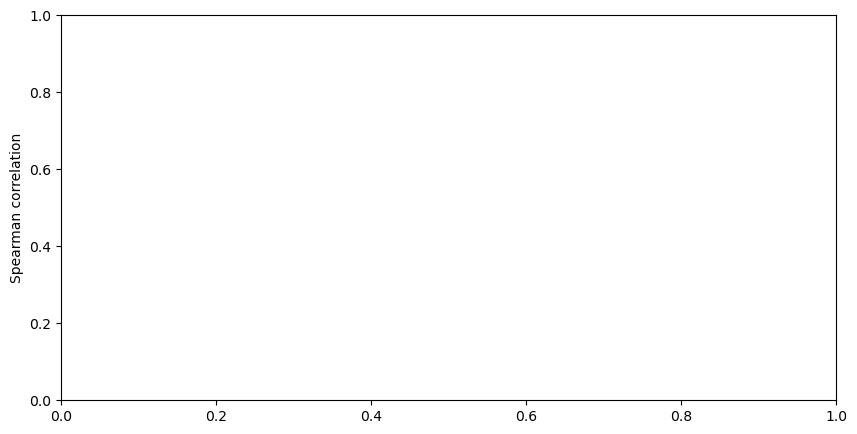

In [145]:
all_scores_agg

# all_scores_err

import seaborn as sns
import pandas as pd

# plot dictionary as swarmplot
# sns.set(style="whitegrid")
plt.figure(figsize=(10, 5))
sns.swarmplot(data=pd.DataFrame(all_smape_scores))
plt.ylabel("Spearman correlation")
plt.show()


In [146]:
pd.DataFrame(all_smape_scores)

,shrec,pca,sfa,ica,kf,cca,fpca,dca,gpfa,cae
spearman,"[0.19454362617450469, 0.58600276001104, 0.0426...","[0.32308718034872136, 0.2908084912339649, 0.13...","[0.5930217320869283, 0.18444496177984712, 0.06...","[0.32308718034872136, 0.2908084912339649, 0.13...","[0.06853486613946456, 0.3026078984315937, 0.72...","[0.5108778648168067, 0.19883673920736697, 0.29...","[0.08806576026304104, 0.043215820863283454, 0....","[0.2488943395773583, 0.32540386161544643, 0.03...","[0.1953066372265489, 0.0767564350257401, 0.210...","[0.13737078948315792, 0.6584946659786639, 0.42..."
acc,"[0.0, 0.0, 0.0, 0.5, 0.0, 0.5, 0.0, 0.5, 0.5, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.5, 0.0, 0.0, 0.5, 0.5, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, ...","[0.5, 0.0, 0.0, 0.5, 0.5, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.5, 0.0, 0.5, 0.5, 0.0, 0.5, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, ...","[0.5, 0.5, 0.0, 0.5, 0.0, 0.0, 0.5, 0.0, 0.0, ...","[0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, ..."


In [133]:
similar_indices(X_measure, y_shrec)

array([9, 4])

In [134]:
true_indices

array([5, 1])

In [119]:
all_smape_scores

{'shrec': {'spearman': [0.19454362617450469], 'acc': [0.0]},
 'pca': {'spearman': [0.32308718034872136], 'acc': [0.0]},
 'sfa': {'spearman': [0.5930217320869283], 'acc': [0.5]},
 'ica': {'spearman': [0.32308718034872136], 'acc': [0.0]},
 'kf': {'spearman': [0.06853486613946456], 'acc': [0.0]},
 'cca': {'spearman': [0.5108778648168067], 'acc': [0.5]},
 'fpca': {'spearman': [0.0814636218544874], 'acc': [0.0]},
 'dca': {'spearman': [0.24870397081588325], 'acc': [0.0]},
 'gpfa': {'spearman': [0.1616057984231937], 'acc': [0.0]},
 'cae': {'spearman': [0.07036818547274189], 'acc': [0.0]}}

In [77]:
param_cca_best = np.median(all_param_cca_best)
param_fpca_best = np.mean(all_param_fpca_best)
param_dca_best = np.median(all_param_dca_best)
param_gpfa_best = np.median(all_param_gpfa_best)
param_cae_best = np.median(np.array(all_param_cae_best), axis=0)
print(param_cca_best, param_fpca_best, param_dca_best, 
      param_gpfa_best, param_cae_best)

5.0 0.8206000000000002 5.0 20.0 [1.0e-02 1.6e+01]


In [50]:
spearmanr(y_driver, y_shrec)

SignificanceResult(statistic=0.29034087336349346, pvalue=3.614383516635075e-11)

In [43]:
from scipy.stats import spearmanr

spearmanr(y_driver, y_cae)

SignificanceResult(statistic=0.6292944211776846, pvalue=1.694661764288111e-56)

(3.4, 3.7)

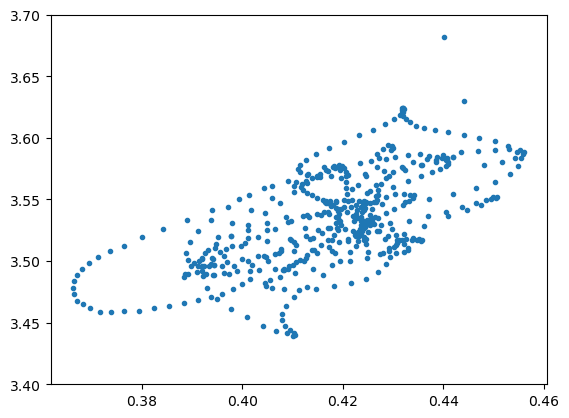

In [46]:
plt.plot(y_driver, y_cae, '.')
plt.ylim(3.4, 3.7)

0.7569950971173636


SignificanceResult(statistic=0.5596928947715791, pvalue=1.4627691842178956e-42)

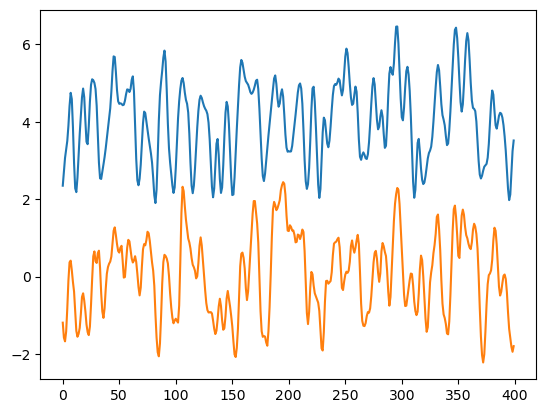

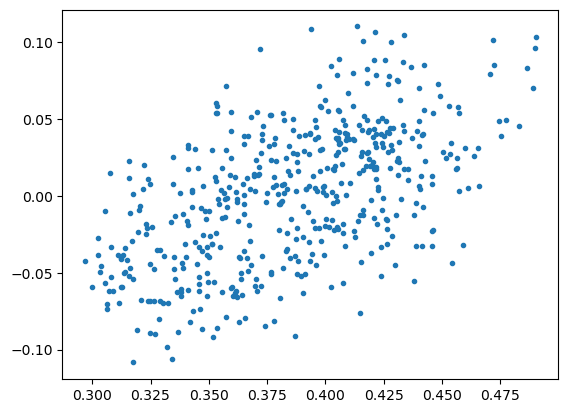

In [222]:
from surrogate import CausalGraph
from simplex import simplex_to_links
from metrics import compute_metrics_indices

nval = 12
cg = CausalGraph(
    nval, 
    random_state=0, 
    amplitude=0.063, 
    measurement_noise=0.0, 
    sparsity=1.0, 
    interactions=np.zeros((nval, nval)), 
    engine="logistic",
    # engine="michaelis",
    higher_order=True,
    higher_k=1
)
X = cg.sample_dynamics(520)[20:]
np.max(X)

from simplex import  SparseTensor3D
np.random.seed(0)
driver_indices = np.random.choice(np.arange(cg.n), size=2, replace=False)
indices_vals = [(i, driver_indices[0], driver_indices[1]) for i in range(cg.n)]
sign_vals = 0.95*np.ones(cg.n)
cg.interactions_3d = SparseTensor3D(
    (cg.n, cg.n, cg.n), 
    indices=indices_vals, 
    values=sign_vals,
)
cg.simplex_indices = indices_vals
X = cg.sample_dynamics(520)[20:]
np.max(X)

# gaussian blur the data along axis 0
from scipy.ndimage import gaussian_filter
X = gaussian_filter(X, sigma=[2, 0])

print(np.max(X))


ind_remove1, ind_remove2 = cg.simplex_indices[0][1], cg.simplex_indices[0][2]
X_measure = np.hstack([X[:, :ind_remove1], X[:, ind_remove1+1:], X[:, ind_remove2:], X[:, ind_remove2+1:]])
X_measure = X.copy()
y_driver = X[:, ind_remove1] * X[:, ind_remove2]


from shrec.models import RecurrenceManifold
model = RecurrenceManifold(random_state=0)
y_reconstructed = model.fit_predict(X_measure)

from shrec.utils import standardize_ts
plt.figure()
plt.plot(4+standardize_ts(y_driver)[:400], '-')
plt.plot(standardize_ts(y_reconstructed)[:400], '-')

plt.figure()
plt.plot(y_driver, y_reconstructed, '.')

from scipy.stats import spearmanr
spearmanr(y_driver, y_reconstructed)

In [287]:
from surrogate import CausalGraph
from simplex import simplex_to_links
from metrics import compute_metrics_indices

nval = 12
cg = CausalGraph(
    nval, 
    random_state=0, 
    amplitude=0.06, 
    measurement_noise=0.0, 
    sparsity=1.0, 
    interactions=np.zeros((nval, nval)), 
    engine="logistic",
    # engine="michaelis",
    higher_order=True,
    higher_k=1
)
X = cg.sample_dynamics(520)[20:]
np.max(X)

# # gaussian blur the data along axis 0
# from scipy.ndimage import gaussian_filter
# X = gaussian_filter(X, sigma=[1, 0])

# print(np.max(X))

0.9985746863473369

In [460]:
from simplex import  SparseTensor3D
np.random.seed(0)

all_scores = list()
all_scores_sfa = list()
all_scores_pca = list()
all_X = list()
all_y = list()
all_driver_inds = list()

# seed_val = 0

nval = 12
for seed_val in range(820):
    cg = CausalGraph(
        nval, 
        random_state=seed_val, 
        amplitude=0.06, 
        measurement_noise=0.0, 
        sparsity=1.0, 
        interactions=np.zeros((nval, nval)), 
        engine="logistic",
        # engine="michaelis",
        higher_order=True,
        higher_k=1
    )
    np.random.seed(seed_val)
    driver_indices = np.random.choice(np.arange(cg.n), size=2, replace=False)
    indices_vals = [(i, driver_indices[0], driver_indices[1]) for i in range(cg.n)]
    sign_vals = 1.05 * np.random.choice([-1, 1], size=cg.n)
    cg.interactions_3d = SparseTensor3D(
        (cg.n, cg.n, cg.n), 
        indices=indices_vals, 
        values=sign_vals,
    )
    cg.simplex_indices = indices_vals
    X = cg.sample_dynamics(520)[20:]
    np.max(X)
    from scipy.ndimage import gaussian_filter
    X = gaussian_filter(X, sigma=[5, 0])
    if np.isnan(np.max(X)):
        continue
    if np.max(np.abs(X)) > 1e5:
        continue
    all_X.append(X.copy())


    ind_remove1, ind_remove2 = cg.simplex_indices[0][1], cg.simplex_indices[0][2]
    X_measure = np.hstack([X[:, :ind_remove1], X[:, ind_remove1+1:], X[:, ind_remove2:], X[:, ind_remove2+1:]])
    X_measure = X.copy()
    y_driver = X[:, ind_remove1] * X[:, ind_remove2]
    all_y.append(y_driver.copy())
    all_driver_inds.append((ind_remove1, ind_remove2))

    y_driver.dump(f"data/combination_regulation/y_driver_{seed_val}.npy")
    X_measure.dump(f"data/combination_regulation/X_measure_{seed_val}.npy")
    np.array(cg.simplex_indices[0]).dump(f"data/combination_regulation/simplex_indices_{seed_val}.npy")

    # y_driver = np.load(f"data/combination_regulation/y_driver_{seed_val}.npy")
    # X_measure = np.load(f"data/combination_regulation/X_measure_{seed_val}.npy")
    # true_indices = np.load(f"data/combination_regulation/simplex_indices_{seed_val}.npy")

    model = RecurrenceManifold(random_state=0)
    y_reconstructed = model.fit_predict(X_measure)

    all_scores.append(spearmanr(y_driver, y_reconstructed).statistic)

    y_pca = PCA(n_components=1).fit_transform(X_measure)[:, 0]
    all_scores_pca.append(spearmanr(y_driver, y_sfa).statistic)

    from sksfa import SFA
    sfa = SFA(n_components=1)
    y_sfa = sfa.fit_transform(X_measure)[:, 0]
    all_scores_sfa.append(spearmanr(y_driver, y_sfa).statistic)
print(len(all_scores))

/Users/william/program_repos/dygene/simplex.py:129: RuntimeWarning: overflow encountered in multiply
  weights=values * vector1[indices[:, 1]] * vector2[indices[:, 2]],
/Users/william/program_repos/dygene/surrogate.py:203: RuntimeWarning: invalid value encountered in add
  x_next += self.amplitude * self.interactions_3d.sparse_contraction(x[-1], x[-1])
/Users/william/program_repos/dygene/simplex.py:129: RuntimeWarning: overflow encountered in multiply
  weights=values * vector1[indices[:, 1]] * vector2[indices[:, 2]],
/Users/william/program_repos/dygene/simplex.py:129: RuntimeWarning: overflow encountered in multiply
  weights=values * vector1[indices[:, 1]] * vector2[indices[:, 2]],
/Users/william/program_repos/dygene/surrogate.py:203: RuntimeWarning: invalid value encountered in add
  x_next += self.amplitude * self.interactions_3d.sparse_contraction(x[-1], x[-1])
/Users/william/program_repos/dygene/simplex.py:129: RuntimeWarning: overflow encountered in multiply
  weights=values * v

152


In [412]:
from scipy.stats import pearsonr
ind_rep = 8
print(np.argsort([np.abs(pearsonr(item, all_y[ind_rep]).statistic) for item in all_X[ind_rep].T])[-2:])
print(all_driver_inds[ind_rep])

[6 0]
(0, 6)


(500, 12)

(500, 13)

In [393]:
from hccm.hccm.ccm import CausalDetection

ccm_model = CausalDetection()
X2 = np.hstack([all_y[3][:, None], all_X[3]])
cmat = ccm_model.fit(X2)

[################### ] 



3 4


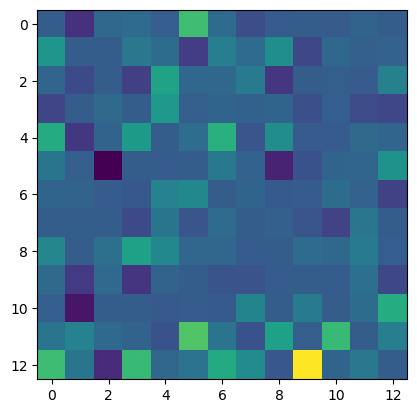

In [394]:
plt.imshow(cmat)
print(ind_remove1, ind_remove2 )

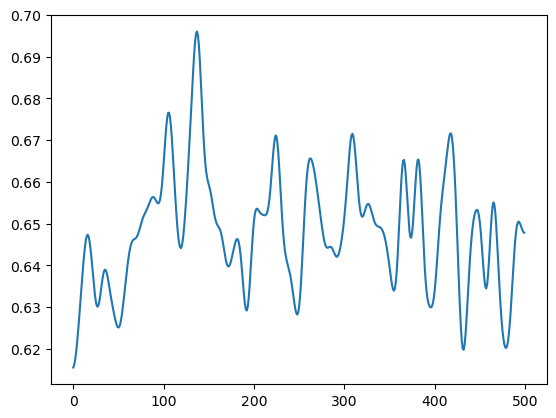

In [369]:
plt.plot(all_X[0][:, 2])

In [348]:
print(np.median(np.abs(all_scores)))
print(np.median(np.abs(all_scores_sfa)))
print(np.median(np.abs(all_scores_pca)))

0.32651530606122425
0.0643208209332847
0.06269386441870659


SignificanceResult(statistic=-0.49546172584690334, pvalue=2.4840063862004795e-32)

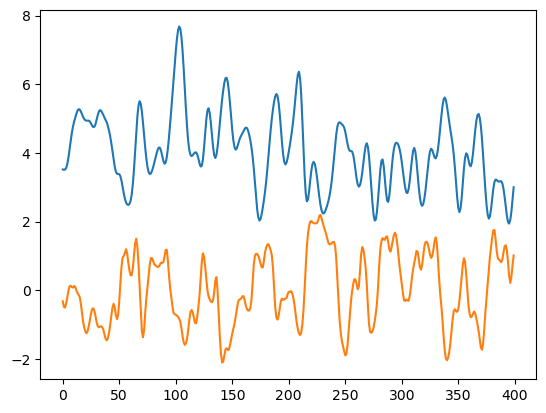

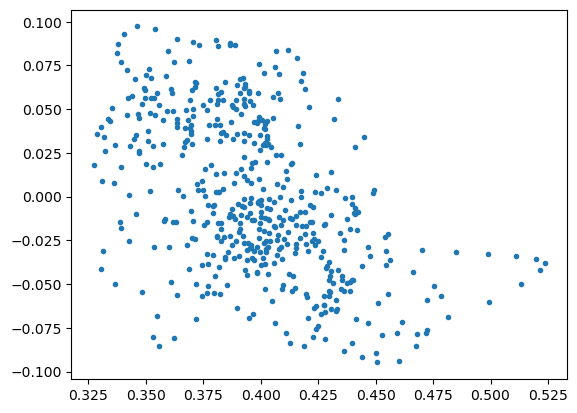

In [271]:
from shrec.models import RecurrenceManifold
model = RecurrenceManifold(random_state=0)
y_reconstructed = model.fit_predict(X_measure)

from shrec.utils import standardize_ts
plt.figure()
plt.plot(4+standardize_ts(y_driver)[:400], '-')
plt.plot(standardize_ts(y_reconstructed)[:400], '-')

plt.figure()
plt.plot(y_driver, y_reconstructed, '.')

from scipy.stats import spearmanr
spearmanr(y_driver, y_reconstructed)

In [431]:
dd = "/Users/william/program_repos/shrec/benchmarks/data/gene_data.npy"

XX = np.load(dd, allow_pickle=True)

print(XX.shape)

(4002, 96)


In [436]:
train_data.shape

(500, 12)

Finished training autoencoder.
SignificanceResult(statistic=0.06047801127521206, pvalue=0.4375193290483784)


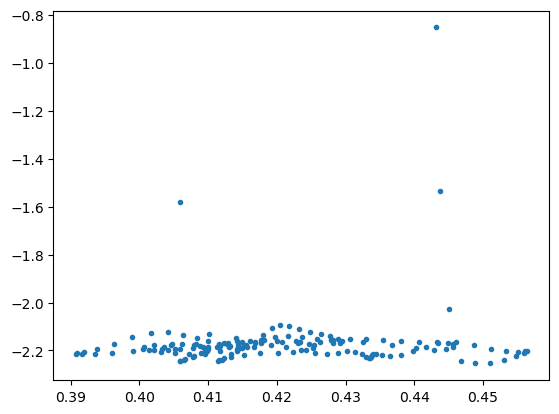

In [448]:
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader 

# train_data = X_measure.copy()[:499]

from causal_encoder import Autoencoder

# params = (1e-4, 16, 1)
# lr, wd, fd = params


# input = torch.tensor(train_data.T[None, ...], dtype=torch.float32)

# train_dataloader = DataLoader(input, batch_size=1, shuffle=True) # only one sample

# model = Autoencoder(fd, input.shape[1], latent_width=wd)
# train_dataloader = DataLoader(input, batch_size=1, shuffle=True) # only one sample  

# criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=1e-2)
# for epoch in range(200): 
#     running_loss = 0.0
#     for i, data_batch in enumerate(train_dataloader):
#         #print(data_batch.shape)
        
#         inputs = data_batch
# #         #print(inputs.shape)
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(inputs, outputs)

#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item()
# print("Finished training autoencoder.", flush=True)
# pred = model.encoder(input).detach().numpy()[0, 0, :]


        
# y_pca = PCA(n_components=1).fit_transform(X_measure)[:, 0]
# from scipy.stats import spearmanr
# print(spearmanr(y_driver, y_pca))
# plt.figure()
# plt.plot(y_driver, y_pca, '.')






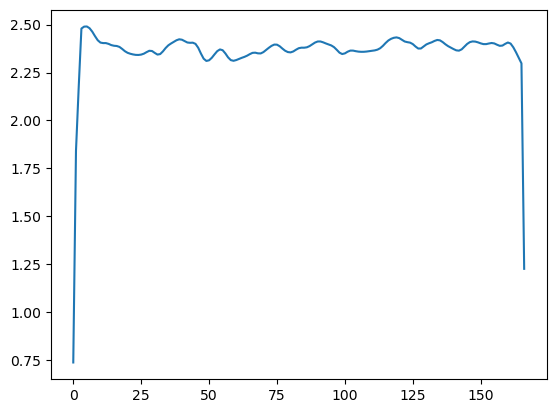

In [444]:
plt.plot(y_cae)



In [ ]:
class CausalAutoencoder:
    def __init__(self, lr=1e-4, wd=16, fd=1):
            self.lr = lr
            self.wd = wd
            self.fd = fd
            self.model = None
            self.criterion = nn.MSELoss()
            self.optimizer = None

SignificanceResult(statistic=0.12134534938139752, pvalue=0.006595256328724624)
SignificanceResult(statistic=0.03886546746186985, pvalue=0.38582651552280967)
SignificanceResult(statistic=0.12134534938139752, pvalue=0.006595256328724624)
SignificanceResult(statistic=0.2986516266065064, pvalue=9.26130027917803e-12)
SignificanceResult(statistic=-0.5587280810070795, pvalue=2.166205667748205e-42)
SignificanceResult(statistic=-0.23675144300577203, pvalue=8.460657157784481e-08)
SignificanceResult(statistic=-0.19619099276397103, pvalue=9.915799033822417e-06)
Initializing parameters using factor analysis...

Fitting GPFA model...
SignificanceResult(statistic=0.17457189828759315, pvalue=8.710978944929788e-05)
Finished training autoencoder.
SignificanceResult(statistic=0.02974172137652406, pvalue=0.702798617293469)


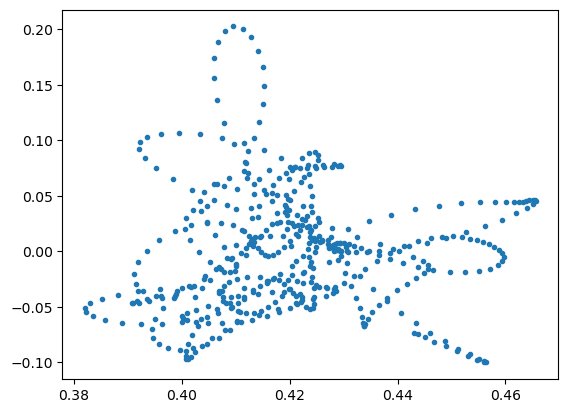

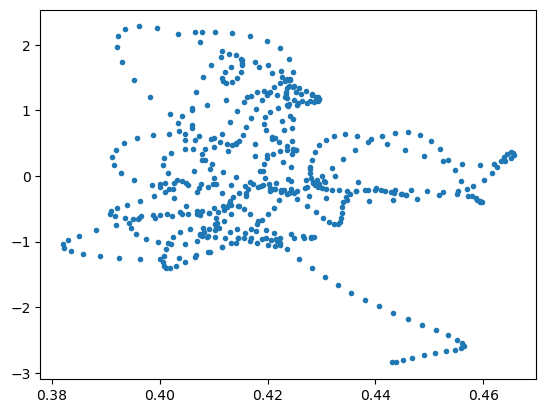

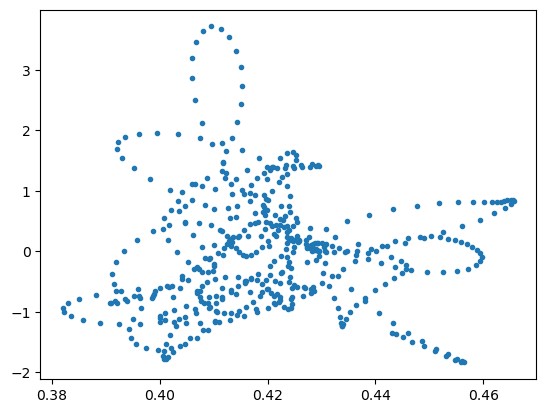

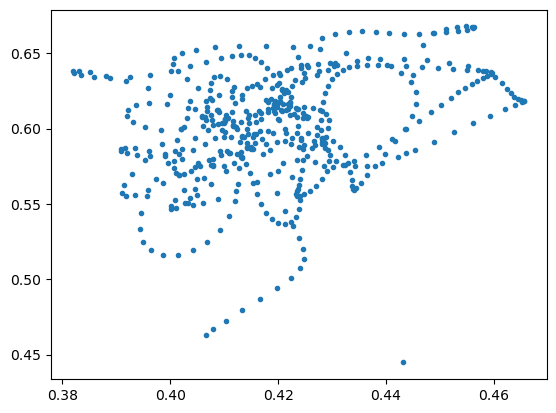

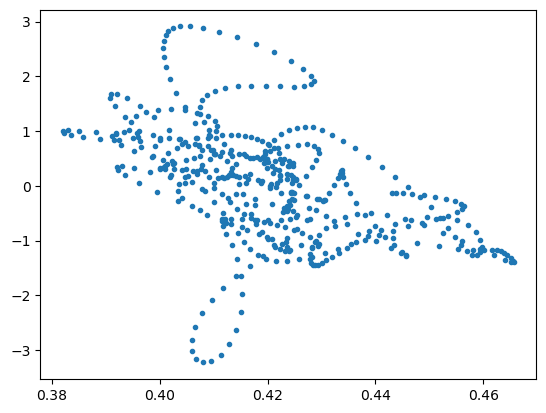

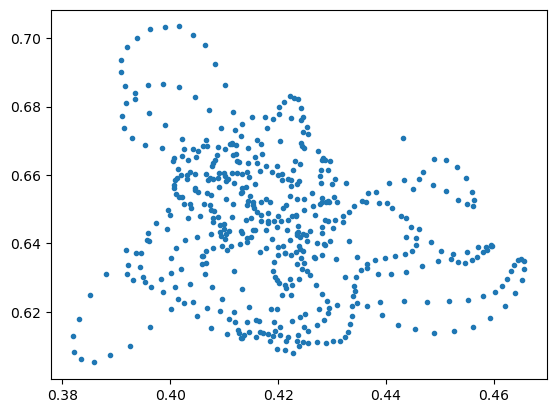

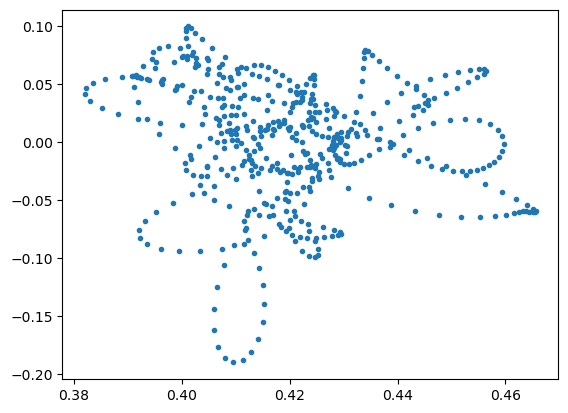

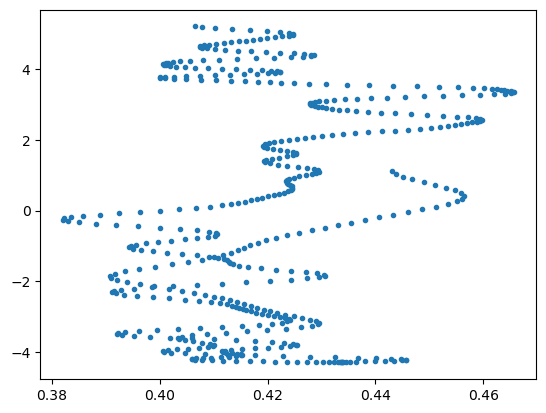

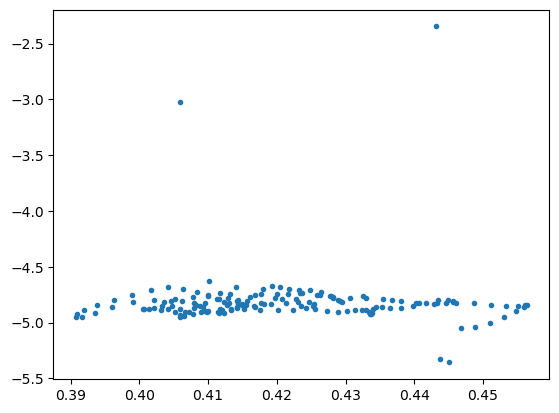

In [455]:

from scipy.stats import spearmanr

from sklearn.decomposition import PCA
y_pca = PCA(n_components=1).fit_transform(X_measure)[:, 0]
print(spearmanr(y_driver, y_pca))
plt.figure()
plt.plot(y_driver, y_pca, '.')


from sksfa import SFA
sfa = SFA(n_components=1)
y_sfa = sfa.fit_transform(X_measure)[:, 0]
print(spearmanr(y_driver, y_sfa))
plt.figure()
plt.plot(y_driver, y_sfa, '.')

## ICA
from sklearn.decomposition import FastICA
ica = FastICA(n_components=1)
y_ica = ica.fit_transform(X_measure)[:, 0]
print(spearmanr(y_driver, y_ica))
plt.figure()
plt.plot(y_driver, y_ica, '.')

import sktime.transformations.series.kalman_filter as kf
y_kf = kf.KalmanFilterTransformerFP(state_dim=1).fit_transform(X_measure)[:, 0]
print(spearmanr(y_driver, y_kf))
plt.figure()
plt.plot(y_driver, y_kf, '.')

from baseline_models import CCATimeSeries
tau = 10
cca = CCATimeSeries(n_components=1, time_lag=tau)
cca.fit(X_measure)
y_cca = cca.transform(X_measure)
print(spearmanr(y_driver, y_cca))
plt.figure()
plt.plot(y_driver, y_cca, '.')

from baseline_models import FourierPCA
fpca = FourierPCA(n_components=1)
y_fpca = fpca.fit_transform(X_measure)#[:, 0]
print(spearmanr(y_driver, y_fpca))
plt.figure()
plt.plot(y_driver, y_fpca, '.')

from dca import DynamicalComponentsAnalysis as DCA
dca = DCA(d=1, T=10)
y_dca = dca.fit_transform(X_measure).squeeze()
print(spearmanr(y_driver, y_dca))
plt.figure()
plt.plot(y_driver, y_dca, '.')

num_trial_vals = [5, 10, 20, 40, 80]
from gpfa import GPFAContinuous
gpfa_model = GPFAContinuous(
    n_components=1, num_trials=20, latent_dimensionality=1
)
y_gpfa = gpfa_model.fit_transform(X_measure).squeeze()
print(spearmanr(y_driver, y_gpfa))
plt.figure()
plt.plot(y_driver, y_gpfa, '.')

from cae import CausalAutoencoder
lr_vals = [1e-1, 1e-2, 1e-3]
width_vals = [8, 16, 32, 64]
causal_autoencoder = CausalAutoencoder(wd=64, lr=1e-3)
y_cae = causal_autoencoder.fit_transform(X_measure[:-1])
print(spearmanr(y_driver[:len(y_cae)], y_cae))
plt.figure()
plt.plot(y_driver[:len(y_cae)], y_cae, '.')


Initializing parameters using factor analysis...

Fitting GPFA model...
Fitting has converged after 125 EM iterations.)
SignificanceResult(statistic=0.14849243396973585, pvalue=0.0008667038131160544)


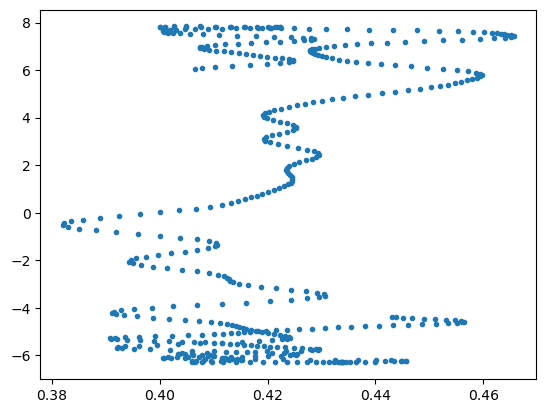

In [421]:
from gpfa import GPFAContinuous
gpfa_model = GPFAContinuous(
    n_components=1, num_trials=60, latent_dimensionality=1
)
y_gpfa = gpfa_model.fit_transform(X_measure).squeeze()
print(spearmanr(y_driver, y_gpfa))
plt.figure()
plt.plot(y_driver, y_gpfa, '.')

Initializing parameters using factor analysis...

Fitting GPFA model...
SignificanceResult(statistic=0.15633115332461328, pvalue=0.0004506131197079729)


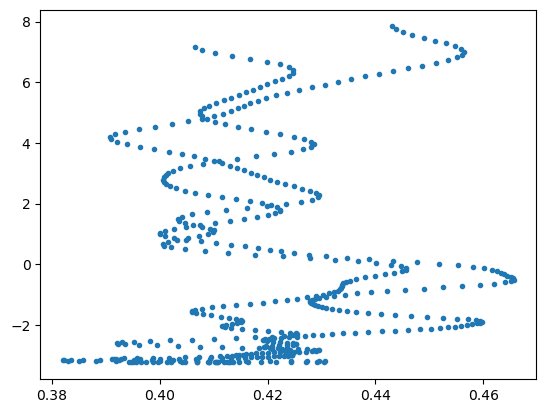

In [417]:
from gpfa import GPFAContinuous
gpfa_model = GPFAContinuous(
    n_components=1, num_trials=19, latent_dimensionality=1
)
y_gpfa = gpfa_model.fit_transform(X_measure).squeeze()
print(spearmanr(y_driver, y_gpfa))
plt.figure()
plt.plot(y_driver, y_gpfa, '.')

SignificanceResult(statistic=-0.0808569954279817, pvalue=0.0708479443356621)


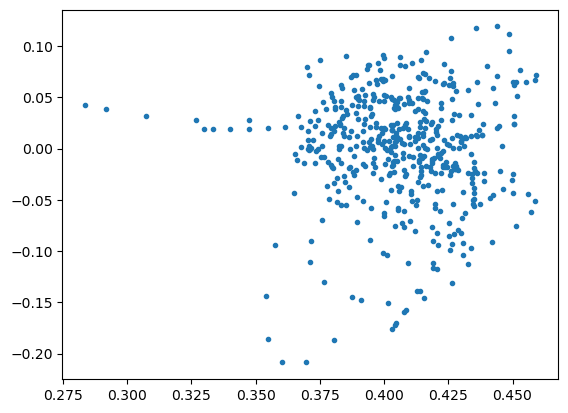

In [283]:

# model = DCA(d=dim_val, T=tau, rng_or_seed=SEED)

In [168]:
# """
# A module for generating synthetic data with a fixed causal graph.
# """
# import numpy as np
# import warnings

# try:
#     from numba import njit
#     _has_numba = True
# except ImportError:
#     warnings.warn("Numba not installed. Integration may be slower.")
#     njit = lambda x: x
#     _has_numba = False

# # logistic_map = lambda x, r: r * x * (1 - x)
# @njit
# def logistic(x, r):
#     return r * x * (1 - x)

# @njit
# def michaelis(x, delta):
#     """
#     X describes an activator, and y describes a repressor. 

#     Reference: 
#     Smolen, Baxter, Byrne.  Am. J. Physiol. 274, C531–C542 (1998)
#     Liu et al. Nonlinear Dynamics. 2022
#     """
#     k1 = 16.0
#     p = 2.0
#     q = 4
#     ell1 = 2.0
#     r = 0.3
#     # x *= 12
#     y = 12 * x / q # assume fast-acting repressor
#     denom = (144 * x**2 + p * (1 + y))
#     xnext = 12 * x + delta * (144 * k1 * x**2 / denom - ell1 * 12 * x + r)
#     return xnext / 12 

# # logistic_map_drive = lambda x: logistic_map(x, 3.8)
# # logistic_map_response = lambda x, xd: logistic_map(x, 3.8) - 0.09 * xd
# minmax_scaler = lambda x, tol=1e-8: (x - np.min(x, axis=0, keepdims=True) + tol) / (np.max(x, axis=0, keepdims=True) - np.min(x, axis=0, keepdims=True) + tol)


# class CausalGraph:
#     """
#     A class for generating and sampling dynamics from a fixed causal network. 
#     Deterministic dynamics are sampled using random maps, which produce pseudorandom 
#     deterministic dynamics. 

#     Uses a coupled map network

#     Attributes:
#         n (int): The number of genes in the system
#         interactions (ndarray): A matrix of shape (n, n) containing the interactions
#             between genes
#         continuity (float): The smoothness of the dynamical process
#         measurement_noise (float): The standard deviation of the measurement noise
#         process_noise (float): The standard deviation of the process noise
#         engine (str): The type of dynamical process to simulate, "logistic" or 
#             "michaelis"
#         random_state (int): The random seed to use
#         non_stationary (bool): Whether to simulate non-stationary dynamics
#         sparsity (float): The sparsity of the causal graph. This should be set to a
#             value between 0 and 1, but ideally below the percolation threshold so that
#             the causal graph is not fully connected.

#     Usage:
#         cg = CausalGraph(10, random_state=0)
#         X = cg.sample_dynamics(100) # Samples 100 timepoints x 10 genes

#     Development:
#         + Extract smoothness from temporal autocorrelation of real data
#         + Morse-Smale dynamics, bifurcations
#         + Postprocessing modules based on splatter modules
#         + Read mean expression levels from a ground truth dataset

#     """


#     def __init__(self, n, 
#                 interactions=None,
#                 amplitude=0.1, 
#                 sparsity = 0.9,
#                 engine="michaelis", 
#                 random_state=None, 
#                 measurement_noise=0.0, 
#                 process_noise=0.0,
#                 continuity=None,
#                 non_stationary=False,
#                 higher_order=False,
#                 higher_k=2,
#         ):
#         self.n = n
#         self.interactions = interactions
#         self.measurement_noise = measurement_noise
#         self.process_noise = process_noise
#         self.amplitude = amplitude
#         self.random_state = random_state
#         self.non_stationary = non_stationary
#         self.sparsity = sparsity
#         self.higher_order = higher_order
#         self.higher_k = higher_k
#         self.continuity = continuity

#         self.engine = engine
#         if self.engine == "logistic":
#             self.engine_func = lambda x: logistic(x, 3.8)
#         elif self.engine == "michaelis":
#             self.engine_func = lambda x: michaelis(x, 1.477)
#         else:
#             warnings.warn("The engine is not recognized. Using the logistic map.")
#             self.engine_func = lambda x: logistic(x, 3.8)


#         if sparsity < (1 - 1 / n):
#             warnings.warn("The sparsity is below the percolation threshold. All variables may appear to be causally connected.")

#         np.random.seed(self.random_state)
#         if interactions is None:
#             self.interactions = self.random_interactions()

#         if self.higher_order:
#             from simplex import generate_tuples, SparseTensor3D
#             simplex_indices = generate_tuples(higher_k, self.n)
#             self.simplex_indices = simplex_indices
#             self.interactions_3d = SparseTensor3D(
#                 (self.n, self.n, self.n), 
#                 indices=self.simplex_indices, 
#                 values=np.ones(len(simplex_indices))
#             )


            

#     def random_interactions(self):
#         # interactions = (self.amplitude / self.n) * np.random.choice([0, 1], size=(self.n, self.n), p=[0.5, 0.5])
#         # interactions = 0.5 * (self.amplitude / self.n) * np.random.uniform(size=(self.n, self.n))

#         if (self.sparsity > 0.7) and (self.n > 100):
#             warnings.warn("The sparsity is high, so a sparse matrix type will be used.")
#             import scipy.sparse as sp
#             # def element_func(n):
#             #     vals = (1 + np.random.exponential(size=n, scale=1/2))
#             #     return (vals / np.max(vals)) * self.amplitude
#             # interactions = sp.random(
#             #     self.n, 
#             #     self.n, 
#             #     density=(1 - self.sparsity), 
#             #     data_rvs=element_func
#             # )
#             # interactions = sp.random(self.n, self.n, density=(1 - self.sparsity))  
#             interactions = sp.random(self.n, self.n, density=(1 - self.sparsity), data_rvs=np.ones)              
#             interactions.setdiag(0)
#             # convert to csr format
#             interactions = interactions.tocsr()
#             return interactions
#         else:
#             interactions = np.random.choice([0, 1], size=(self.n, self.n), p=[self.sparsity, 1 - self.sparsity])
#             # interactions = np.random.exponential(scale=1, size=(self.n, self.n))
#             # np.fill_diagonal(interactions, 0)
#             # threshold = np.percentile(interactions.ravel(), 100 * self.sparsity, interpolation="lower")
#             # interactions[interactions < threshold] = 0
#             return interactions
        
#     def random_simplex(self):
#         interactions = sp.random(self.n, self.n, self.n, density=(1 - self.sparsity), data_rvs=np.ones)      
#         interactions.setdiag(0)
#         interactions = interactions.tocsr()
#         return interactions
    
#     def sample_dynamics(self, nt, ic=None, r=3.8):
#         """
#         Sample time series from the causal graph

#         Args:
#             nt (int): The number of timepoints to sample
#             ic (ndarray): The initial condition for the system
#             r (float): The parameter for the logistic map

#         Returns:
#             ndarray: An array of shape (nt, n) containing the time series

#         """

#         if ic is None:
#             x = [np.random.uniform(size=self.n)]
#         else:
#             x = [np.array(ic)]

#         # x[-1] = x[-1].astype(np.longdouble, copy=False)

#         for _ in range(nt - 1):
#             force = self.interactions.dot(x[-1])
#             # force = np.around(force, 64)
#             # force[force < 1e-8] = 1e-8
#             # print(force[-1])
    
#             # x_next = x[-1] * (r - r * x[-1] - self.amplitude * force)
#             # x_next = logistic(x[-1], r) - x[-1] * self.amplitude * force
#             # x_next = self.engine_func(x[-1]) - x[-1] * self.amplitude * force

#             x_next = self.engine_func(x[-1]) - self.amplitude * force

#             if self.higher_order:
#                 x_next += self.amplitude * self.interactions_3d.sparse_contraction(x[-1], x[-1])


#             x_next += np.random.normal(scale=self.process_noise, size=x_next.shape)
#             x.append(x_next)
#         x = np.array(x)
#         x += np.random.normal(scale=self.measurement_noise, size=x.shape)

#         if self.non_stationary:
#             timescales = np.random.randint(1, nt // 5, size=self.n)
#             fade = np.exp(-np.arange(nt)[None, :] / timescales[:, None]).T
#             x = x * fade + np.mean(x, axis=0)[None, :] * (1 - fade)

#         if self.continuity is not None:
#             from scipy.ndimage import gaussian_filter1d
#             x = gaussian_filter1d(x, self.continuity, axis=0)

#         return x
    


In [ ]:



SparseTensor3D(
    (self.n, self.n, self.n), 
    indices=self.simplex_indices, 
    values=np.ones(len(simplex_indices))
)

12